In [2]:
%load_ext autoreload
%autoreload 2
import networkx as nx
import os
import pickle
from tqdm import tqdm
import numpy as np
import random
from collections import defaultdict
import copy
from wolf import *
from run import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [13]:
list(range(1 , 0, -1))

[1]

In [14]:
PROPOGATION = 0.1
total_runs = 30
ITERATIONS = 100
SEED_SIZE = 25
POPULATION_SIZE = 500

In [15]:
# attribute = "age"
# objectives = {'rationality'}
# demo = simulate(get_graphs(), attribute, objectives, 1, 0, False)
# # demo

In [16]:
records = []
records2 = []
for i in os.listdir("data"):
    with open(os.path.join("data", i), 'r') as json_file:
        record = json.load(json_file)        
        if record["algorithm"]!="SetMOGWO_I":
            records += [record]
        else:
            records2 += [record]
df = pd.DataFrame.from_records(records)
df2 = pd.DataFrame.from_records(records2)
len(df)

9

In [17]:
metirk = df.columns[2:]
df3 = pd.DataFrame([])

for i in range(len(df)):
    attrib = "age"
    a = df.iloc[i]
    b = df2[df2["attribute"]==a["attribute"]].iloc[0]
    yaya = b[metirk]/a[metirk]
    yaya2 = pd.concat([a[:2] , b[metirk]/a[metirk]]).to_frame().T
    yaya2.columns = yaya2.columns[:2].to_list()+["pof_"+i for i in yaya2.columns[2:]]
    df3 = pd.concat([df3,yaya2])

df3.reset_index(drop=True)
len(df)

9

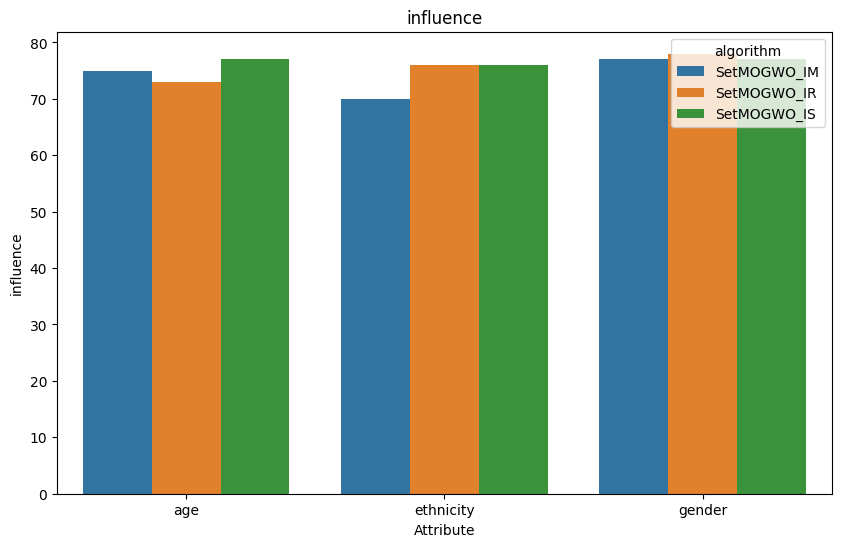

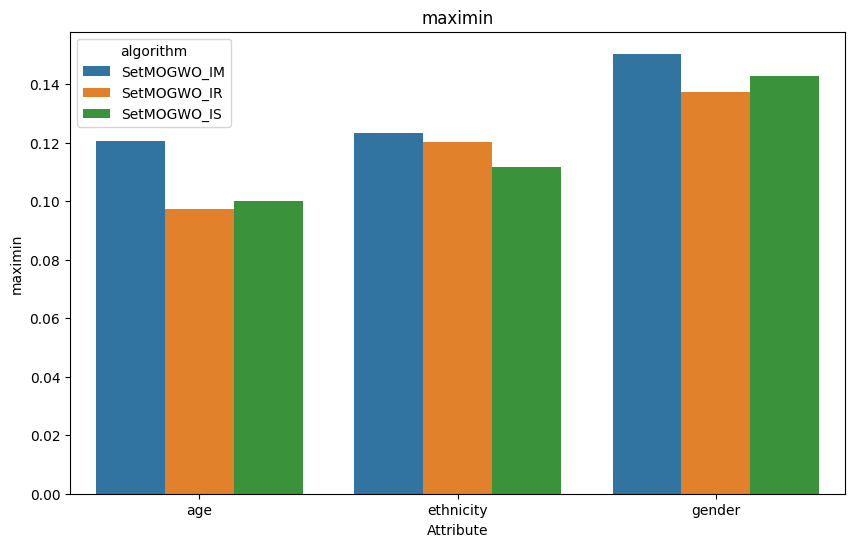

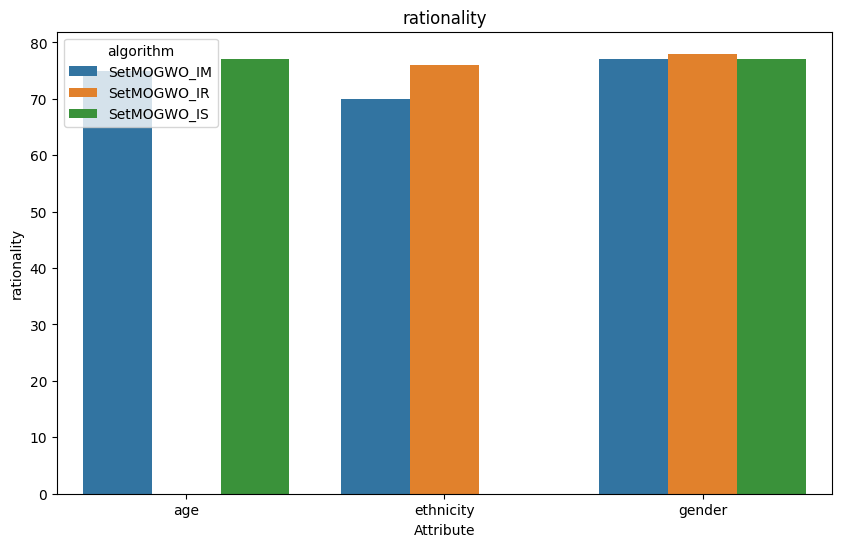

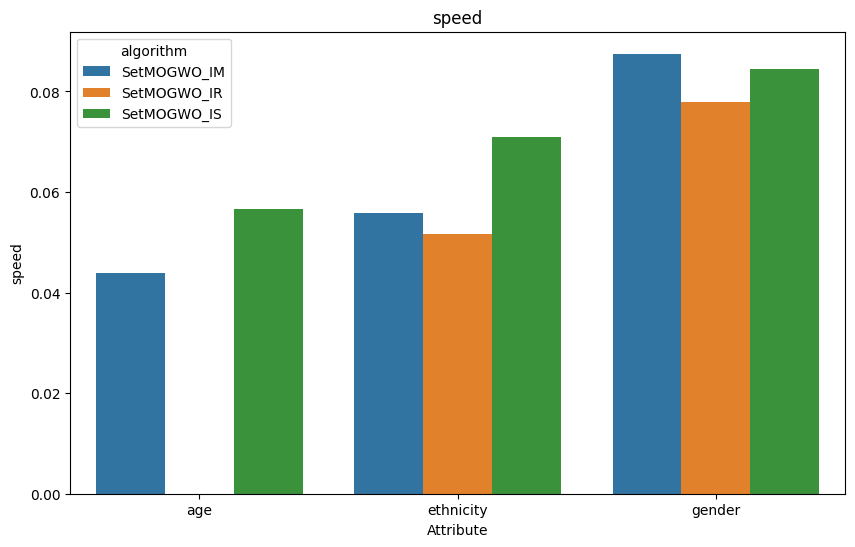

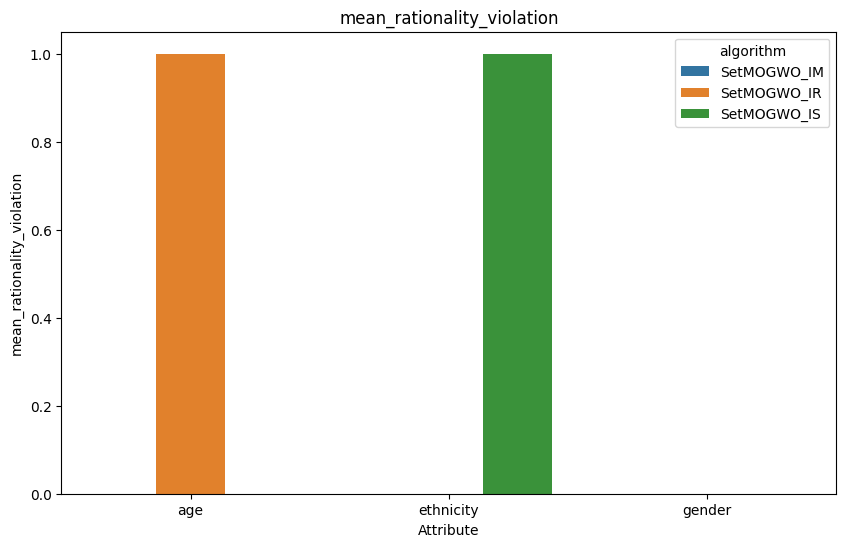

In [19]:
METRIK = ["influence", "maximin", "rationality", "speed", "mean_rationality_violation"]

for i in METRIK:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='attribute', y=i, hue='algorithm')
    plt.title(i)
    plt.xlabel('Attribute')
    plt.ylabel(i)
    plt.show()


In [ ]:
# METRIK2 = ["pof_"+i for i in METRIK]
# for i in METRIK2:
#     plt.figure(figsize=(10, 6))
#     sns.barplot(data=df3, x='attribute', y=i, hue='algorithm')
#     plt.title(i)
#     plt.xlabel('Attribute')
#     plt.ylabel(i)
#     plt.show()


# Saved Code

In [ ]:

# if pof:
#     results2 =[]
#     for _ in range(repetitions):
#         for g in tqdm(GRAPHS):
#             archive = setmogwo(g, attribute, {})
#             for arch in archive:
#                 results2 += [[arch.influence_metric(), arch.maximin_fairness_metric(), arch.group_rationality_metric(), arch.group_activation_speed_metric()]]
#             if check==True:
#                 break
            
#     results2 = np.array(results2)
#     return np.concatenate((np.average(results, axis=0),
#                     np.array([sum(results[:,2]==0)/len(results)]), 
#                     np.average(results2, axis=0)/(np.average(results, axis=0))))
# else: 